<a href="https://colab.research.google.com/github/Maagnitude/coupon-recommend-models/blob/main/coupon_recommend_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Βασική Εργασία** στο μάθημα **Εξόρυξη Δεδομένων**

# **Τμήμα Πληροφορικής και Τηλεματικής - Χαροκόπειο Πανεπιστήμιο**

## **Χαρίτος Δημήτριος -------------------- it21395**
## **Καζάζης Γεώργιος --------------------- it214124**
## **Ζαρρή Σωτηρία Νικολίτσα ------------ it219141**

Στην παρούσα εργασία θα αναπτύξουμε **μοντέλα κατηγοριοποίησης**, για να εξετάσουμε το πρόβλημα του συστήματος **κουπονιών**. Δηλαδή το σε ποιους πιθανούς πελάτες, πρέπει να προσφέρουμε κάποιο κουπόνι, το οποίο πάντα ήταν ένα μεγάλο πρόβλημα, και με τεχνικές **Μηχανικής Μάθησης** θα προσπαθήσουμε να δημιουργήσουμε ένα καλύτερο σύστημα συστάσεων κουπονιών.

Ύστερα θα αναπτύξουμε **μοντέλα συσταδοποίησης**, για να εξετάσουμε και την πλευρά των μοντέλων χωρίς επίβλεψη (**unsupervised**), στην αντιμετώπιση του παρόντος προβλήματος.

**Αρχίζοντας...**

# **Βιβλιοθήκες**
Κάνουμε import τα απαραίτητα **modules**. 
*   Την **pandas** και την **numpy** για την διαχείριση των δεδομένων μας.

*  Την **matplotlib.pyplot** και την **seaborn** για την οπτικοποίηση των δεδομένων μας. **Ιστογράμματα**, **heatmaps** κλπ.

*  Την **missingno** ώστε να οπτικοποιήσουμε το αν υπάρχουν ελλιπείς εγγραφές.

*   Από την **sklearn** κάνουμε import:
      *   Την **linear_model** για να εκπαιδεύσουμε το **Logistic Regression model**.
      *   Την **model_selection** για την εισαγωγή του **train_test_split** για το χώρισμα του train και του test sets.
      *  Από το **neighbors**, βάζω το **KNeighborsClassifier** για την ανάπτυξη ενός kNN μοντέλου.
      *  Από το **metrics**, βάζω το **accuracy_score**.
      *  Την **RandomForestClassifier** για να εκπαιδεύσουμε ένα Random Forest model.
*  Το **tensorflow**, και από αυτό, τα **keras** και **layers** για την ανάπτυξη νευρωνικών δικτύων.

*  Τέλος, κάνουμε import τα **warnings** και τα φιλτράρουμε, ώστε να μην εμφανίζονται.

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import missingno as msno

from sklearn.impute import SimpleImputer
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score, precision_recall_curve

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings(action='ignore')

# **A) EDA - Preprocessing / Προετοιμασία**
Το **πρώτο μέρος** αφορά την **προετοιμασία** των δεδομένων, από την **φόρτωση** τους, μέχρι τον **καθαρισμό** τους (το **πέταμα** όσων δεν χρειάζονται, την **συμπλήρωση** των τιμών **null** κτλ.), και το **χώρισμα** τους σε **train-test sets**. Επίσης θα υπάρξουν επεξηγηματικά **plots**, όπου χρειάζεται.

## **Φόρτωση του dataset από το csv αρχείο**
Περνάμε το **url** του dataset στην μεταβλητή df με την χρήση της μεθόδου **read_csv**, και εκτυπώνουμε τις 5 πρώτες γραμμές για να δούμε ότι έγιναν όλα σωστά.

Το **url** είναι του **raw dataset** απ το repository μου στο **github**.

In [37]:
url = "https://raw.githubusercontent.com/Maagnitude/coupon_recommend_models/main/in-vehicle-coupon-recommendation.csv"
df = pd.read_csv(url)
df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


## **Άλλος τρόπος φόρτωσης (Drive mount)**

In [ ]:
# from google.colab import files
# uploaded = files.upload()
# from google.colab import drive
# drive.mount('/content/drive/')
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/in-vehicle-coupon-recommendation.csv')

## **Σχήμα του Dataframe**. 

Έχουμε ένα **dataframe** σχήματος **12684 x 26**.

**12684 εγγραφές** (δείγματα) και **26 χαρακτηριστικά** (features)

In [38]:
df.shape

(12684, 26)

## **Ελλιπείς εγγραφές**
Με την χρήση του **df.info()**, παρατηρούμε ότι υπάρχουν **ελλιπείς εγγραφές**. Το χαρακτηριστικό **car** έχει μόνο **108 τιμές** που **δεν είναι null**, από τις **12684**. Το καλύτερο εδώ είναι να **πετάξουμε** αυτό το χαρακτηριστικό μιας και δεν μας προσφέρει κάτι. Ύστερα με την χρήση του **df.isnull().sum()**, θα δούμε ακριβώς πόσες τιμές είναι **null** σε κάθε χαρακτηριστικό. Επίσης οπτικοποιούμε τις ελλιπείς εγγραφές με την χρήση της βιβλιοθήκης **missingno**.

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

In [40]:
df.isnull().sum()

destination                 0
passanger                   0
weather                     0
temperature                 0
time                        0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
has_children                0
education                   0
occupation                  0
income                      0
car                     12576
Bar                       107
CoffeeHouse               217
CarryAway                 151
RestaurantLessThan20      130
Restaurant20To50          189
toCoupon_GEQ5min            0
toCoupon_GEQ15min           0
toCoupon_GEQ25min           0
direction_same              0
direction_opp               0
Y                           0
dtype: int64

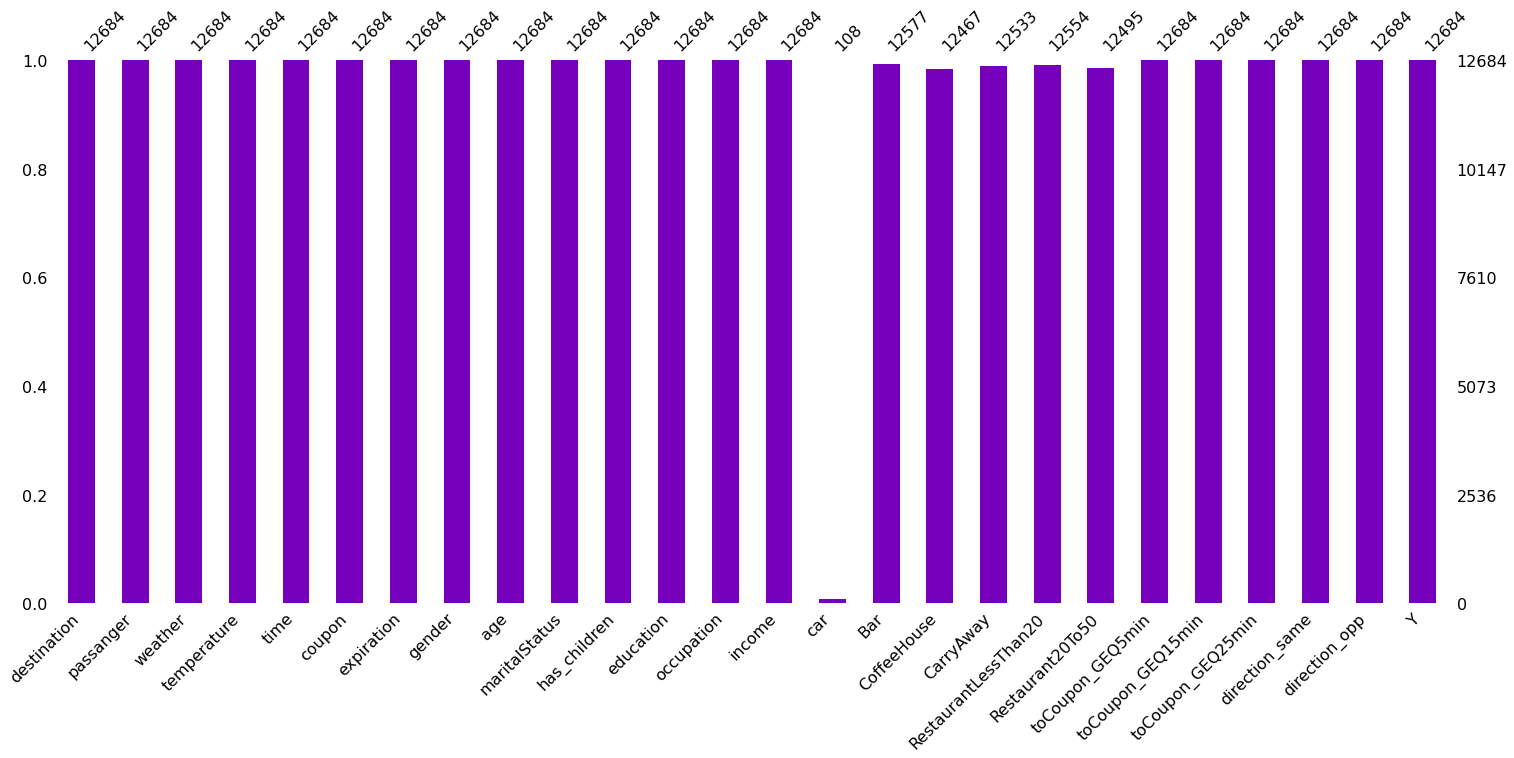

In [41]:
null_plot = msno.bar(df, color="#7600BC")

In [42]:
df= df.drop("car", axis='columns')

## **Imputing**
Εδώ ελέγχουμε τον αριθμό των τιμών για κάθε κατηγορική τιμή. Φαίνεται σαν μια καλή στρατηγική για κάθε τιμή null, να την γεμίζουμε με την τιμή που εμφανίστηκε **πιο συχνά** στις υπόλοιπες εγγραφές (**impute**). 

Ύστερα ελέγχουμε να δούμε ότι δεν υπάρχουν καθόλου null τιμές στις εγγραφές μας με την χρήση της **df.isnull().sum()**.

In [43]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df['Bar'] = imputer.fit_transform(df['Bar'].values.reshape(-1,1))[:,0]

In [44]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df['CoffeeHouse'] = imputer.fit_transform(df['CoffeeHouse'].values.reshape(-1,1))[:,0]

In [45]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df['CarryAway'] = imputer.fit_transform(df['CarryAway'].values.reshape(-1,1))[:,0]

In [46]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df['RestaurantLessThan20'] = imputer.fit_transform(df['RestaurantLessThan20'].values.reshape(-1,1))[:,0]

In [47]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df['Restaurant20To50'] = imputer.fit_transform(df['Restaurant20To50'].values.reshape(-1,1))[:,0]

In [48]:
df.isnull().sum()

destination             0
passanger               0
weather                 0
temperature             0
time                    0
coupon                  0
expiration              0
gender                  0
age                     0
maritalStatus           0
has_children            0
education               0
occupation              0
income                  0
Bar                     0
CoffeeHouse             0
CarryAway               0
RestaurantLessThan20    0
Restaurant20To50        0
toCoupon_GEQ5min        0
toCoupon_GEQ15min       0
toCoupon_GEQ25min       0
direction_same          0
direction_opp           0
Y                       0
dtype: int64

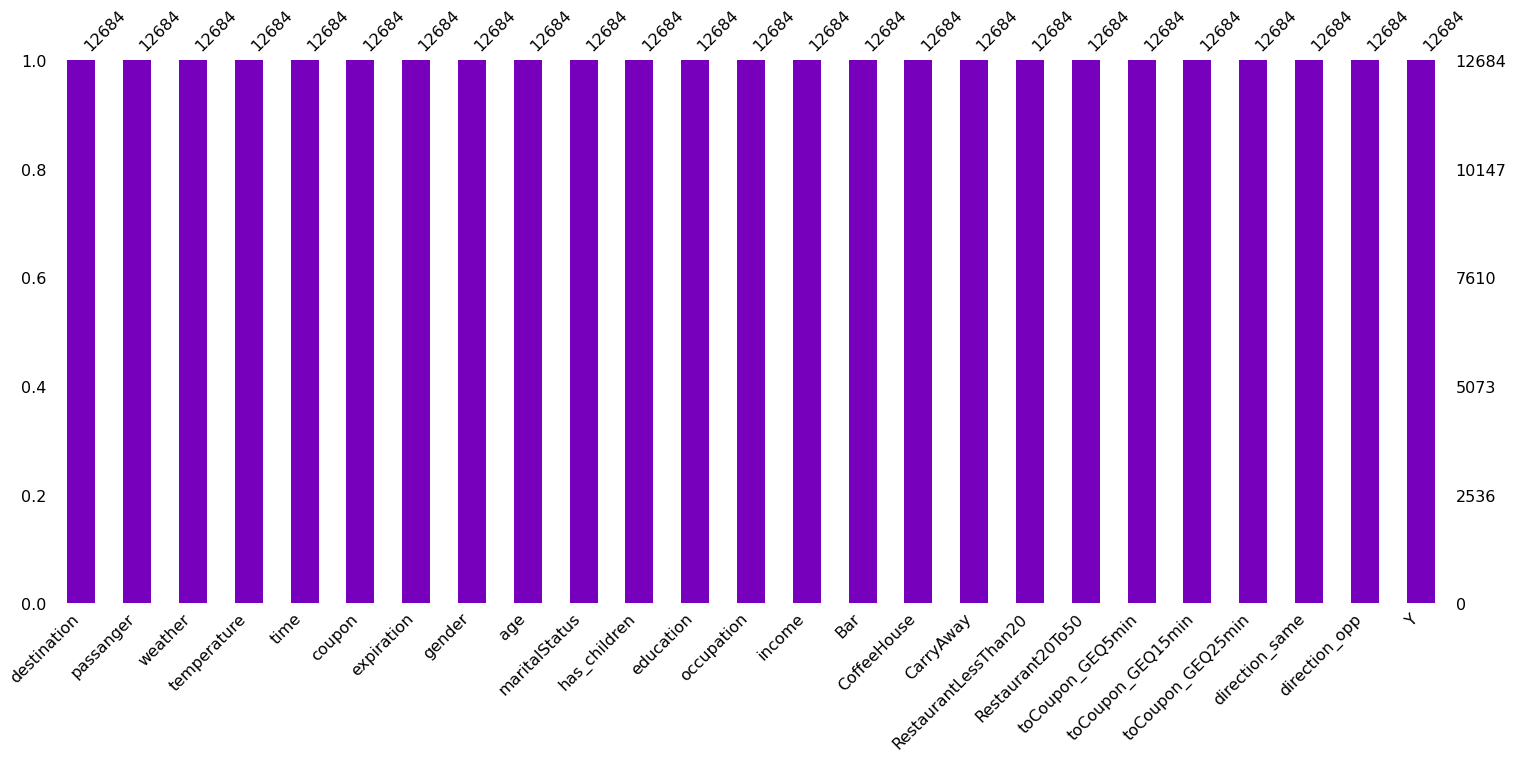

In [49]:
new_null_plot = msno.bar(df, color="#7600BC")

## **Μοναδικές τιμές**
Ελέγχουμε τις μοναδικές (**διαφορετικές**) τιμές που μπορούν να λάβουν τα ποσοτικά χαρακτηριστικά μας, με την χρήση της **nunique()**, και παρατηρούμε ότι το χαρακτηριστικό "**toCoupon_GEQ5min**" παίρνει μόνο μία τιμή, οπότε δεν το χρειαζόμαστε, και θα το πετάξουμε.

In [81]:
df.select_dtypes('int64').nunique()

temperature          3
has_children         2
toCoupon_GEQ15min    2
toCoupon_GEQ25min    2
direction_same       2
Y                    2
dtype: int64

In [51]:
df.drop(columns=['toCoupon_GEQ5min'], inplace=True)

Επίσης τυπώνοντας τον αριθμό της κάθε τιμής που λαμβάνει το "**direction_opp**" και το "**direction_same**", παρατηρούμε ότι στον αριθμό εγγραφών που το ένα έχει **0**, το άλλο έχει **1**, και το αντίστροφο (όπως άλλωστε καταλαβαίνουμε και από την ονομασία του χαρακτηριστικού). Οπότε μας φτάνει να κρατήσουμε το ένα (**direction_same**), γιατί το άλλο είναι **άχρηστη πληροφορία**.

In [52]:
df['direction_same'].value_counts()

0    9960
1    2724
Name: direction_same, dtype: int64

In [53]:
df['direction_opp'].value_counts()

1    9960
0    2724
Name: direction_opp, dtype: int64

In [54]:
df.drop(columns=['direction_opp'], inplace=True)

## **Διπλότυπες Εγγραφές**
Ύστερα πετάμε τις **διπλότυπες εγγραφές** (**drop duplicates**) γιατί και δεν μας προσφέρουν κάτι, και μπορεί να **υπερεκπαιδευτούν** (**overfitting**) τα μοντέλα μας.

In [55]:
df.shape

(12684, 23)

In [56]:
df.drop_duplicates(inplace=True)
df.shape

(12610, 23)

## **Ιστόγραμμα**
Κάνουμε plot το ιστόγραμμα κάθε **ποσοτικού** χαρακτηριστικού ξεχωριστά (και του **label - Y**). Δεν μας βοηθάει ιδιαίτερα μιας και τα **5 από τα 6** ιστογράμματα έχουν ως τιμές τα **0 και 1**, οπότε δεν μπορεί να παρατηρηθεί κάποια ουσιαστική **κατανομή**. Μόνο το ότι το "toCoupon_GEQ25min" έχει πάνω από 10000 εγγραφές με την τιμή 0, και ότι στο "temperature" παρατηρείται **αρνητική ασυμμετρία** (περισσότερες εγγραφές να έχουν την τιμή **80**, λιγότερες την **55** και ακόμα πιο λίγες την **30**) 

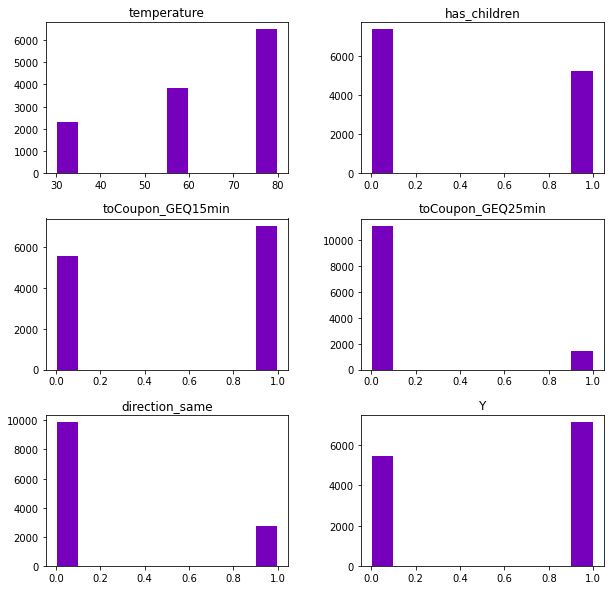

In [57]:
df_histplot = df.hist(grid=False, figsize=(10,10), color='#7600BC', zorder=2, rwidth=0.95)

## **Describe**
Παρακάτω εμφανίζουμε την στατιστική ανάλυση των ποσοτικών δεδομένων μας, με την χρήση της μεθόδου **describe()**. Πάλι δεν βγάζουμε κάποιο παραπάνω συμπέρασμα πέρα από αυτό που μπορούσαμε να δούμε και στο ιστόγραμμα σχετικά με το πόσες εγγραφές αντιστοιχούν σε κάθε τιμή χαρακτηριστικού.

Σημ: Με **Transpose (.T)** ο πίνακας είναι πιο ευκρινής.

In [58]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
temperature,12610.0,63.267248,19.153386,30.0,55.0,80.0,80.0,80.0
has_children,12610.0,0.414512,0.492657,0.0,0.0,0.0,1.0,1.0
toCoupon_GEQ15min,12610.0,0.559794,0.496432,0.0,0.0,1.0,1.0,1.0
toCoupon_GEQ25min,12610.0,0.116019,0.320260,0.0,0.0,0.0,0.0,1.0
direction_same,12610.0,0.215543,0.411215,0.0,0.0,0.0,0.0,1.0
Y,12610.0,0.567565,0.495434,0.0,0.0,1.0,1.0,1.0


## **Ετεροσυσχέτιση**
Με την χρήση της συνάρτησης **corr()** της βιβλιοθήκης **pandas**, ελέγχουμε την **ετεροσυσχέτιση** μεταξύ των χαρακτηριστικών. Συγκεκριμένα τυπώνουμε την συσχέτιση όλων των χαρακτηριστικών με το **label** μας - '**Y**', και παρακάτω θα οπτικοποιήσουμε τις συσχετίσεις όλων.

In [60]:
corr = df.corr()
corr['Y']

temperature          0.059393
has_children        -0.045056
toCoupon_GEQ15min   -0.082693
toCoupon_GEQ25min   -0.108139
direction_same       0.014932
Y                    1.000000
Name: Y, dtype: float64

## **Heatmap**
Εδώ οπτικοποιούμε την **ετεροσυσχέτιση** των χαρακτηριστικών. Αυτή η δισδιάστατη αναπαράσταση μας βοηθάει να καταλάβουμε πολύ πιο εύκολα την ετεροσυσχέτιση, μέσω των χρωμάτων, αλλά και των τιμών. Παρατηρούμε όπως και πιο πάνω, ότι μεγαλύτερη συσχέτιση με το **Y** έχει το **toCoupon_GEQ25min** και πιο συγκεκριμένα αρνητική συσχέτιση. (**-0.1**)

Σημ: Είχαμε δει και στο ιστόγραμμα ότι αυτό το χαρακτηριστικό έχει την **τιμή 0** σε **πάνω από 10000 εγγραφές**.

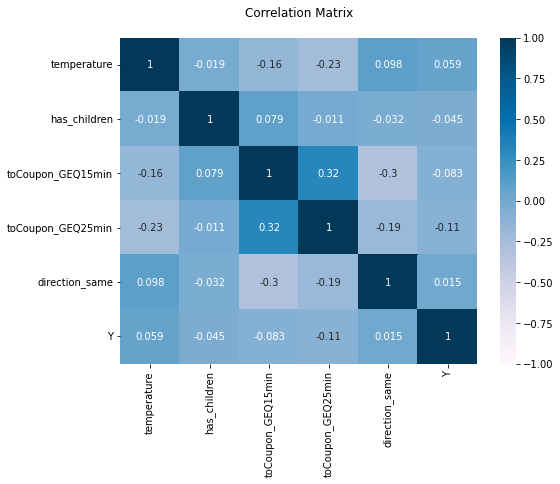

In [61]:
plt.figure(figsize=(8,6))
heat = sns.heatmap(corr, annot=True, vmin=-1.0, cmap='PuBu')
plt.title("Correlation Matrix\n")
plt.show()

## **Pre-One-Hot Dataframe**
Σε αυτό το σημείο θα πάρουμε ένα **αντίγραφο** του **dataframe** μας, πριν κάνουμε **one-hot encoding**, για να το χρησιμοποιήσουμε για το **δεύτερο ερώτημα** που αφορά την εκπαίδευση μοντέλου σε ένα υποσύνολο **5 γνωρισμάτων**.

In [63]:
sec_df = df.copy()

## **ONE-HOT ENCODING**

Εν συνεχεία, θα μετατρέψουμε κάθε **κατηγορικό** χαρακτηριστικό σε "**αριθμητικό**" με την χρήση του **one-hot encoding**, δημιουργώντας τόσες στήλες όσες είναι οι διαφορετικές τιμές του χαρακτηριστικού, και δίνοντας του **1** στην στήλη της τιμής που είχε η κάθε εγγραφή, και **0** σε όλες τις υπόλοιπες. (αυτοματοποιημένη διαδικασία)

**object -> uint8**

In [64]:
df.dtypes

destination             object
passanger               object
weather                 object
temperature              int64
time                    object
coupon                  object
expiration              object
gender                  object
age                     object
maritalStatus           object
has_children             int64
education               object
occupation              object
income                  object
Bar                     object
CoffeeHouse             object
CarryAway               object
RestaurantLessThan20    object
Restaurant20To50        object
toCoupon_GEQ15min        int64
toCoupon_GEQ25min        int64
direction_same           int64
Y                        int64
dtype: object

Παίρνουμε όλα τα **κατηγορικά** (χωρίς τις ποσοτικά) και τα εισάγουμε στην μεταβλητή **df_categorical**. Ύστερα με την χρήση της **get_dummies** των **pandas**, εφαρμόζουμε το **one-hot encoding**. 

Μετά από αυτό τα χαρακτηριστικά μας, από **23**, έχουν γίνει **108** (δηλαδή 108 στήλες), και πλέον μπορούμε να εκπαιδεύσουμε τα μοντέλα μας πάνω σε αυτά.

In [65]:
df_categorical = df.select_dtypes(exclude='number')

In [66]:
df_categorical.head()

,destination,passanger,weather,time,coupon,expiration,gender,age,maritalStatus,education,occupation,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50
0,No Urgent Place,Alone,Sunny,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3
1,No Urgent Place,Friend(s),Sunny,10AM,Coffee House,2h,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3
2,No Urgent Place,Friend(s),Sunny,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3
3,No Urgent Place,Friend(s),Sunny,2PM,Coffee House,2h,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3
4,No Urgent Place,Friend(s),Sunny,2PM,Coffee House,1d,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3


In [67]:
for value in df_categorical:
  df = pd.get_dummies(df, columns=[value])

In [68]:
df.dtypes

temperature               int64
has_children              int64
toCoupon_GEQ15min         int64
toCoupon_GEQ25min         int64
direction_same            int64
                          ...  
Restaurant20To50_1~3      uint8
Restaurant20To50_4~8      uint8
Restaurant20To50_gt8      uint8
Restaurant20To50_less1    uint8
Restaurant20To50_never    uint8
Length: 108, dtype: object

In [69]:
df.head()

,temperature,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,Y,destination_Home,destination_No Urgent Place,destination_Work,passanger_Alone,...,RestaurantLessThan20_1~3,RestaurantLessThan20_4~8,RestaurantLessThan20_gt8,RestaurantLessThan20_less1,RestaurantLessThan20_never,Restaurant20To50_1~3,Restaurant20To50_4~8,Restaurant20To50_gt8,Restaurant20To50_less1,Restaurant20To50_never
0,55,1,0,0,0,1,0,1,0,1,...,0,1,0,0,0,1,0,0,0,0
1,80,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
2,80,1,1,0,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
3,80,1,1,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
4,80,1,1,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0


## **Clustering Dataframe**
Τώρα που το **dataset** μας είναι έτοιμο προς χρήση για **εκπαίδευση**, πριν θα πάρουμε ένα **αντίγραφο** του για να το χρησιμοποιήσουμε στο **Clustering** αργότερα.

In [70]:
cluster_df = df.copy()

# **Β) Classification / Κατηγοριοποίηση** 
Στο **δεύτερο μέρος** ακολουθούν οι **εκπαιδεύσεις** και οι **προβλέψεις 6 μοντέλων κατηγοριοποίησης**
* **Logistic Regression**
* **KNN Algorithm**
* **SVM Algorithm**
* **Decision Tree**
* **Random Forest**
* **Naive Bayes**

καθώς κι ενός **Νευρωνικού δικτύου**.

Πρώτα χωρίζουμε το **dataset** σε **train** και **test sets**, με την χρήση της **συνάρτησης** που υλοποιούμε παρακάτω.

## **Συνάρτηση για train-test splitting**
Ορίζουμε την εξής συνάρτηση για όσες φορές χρειαστεί στην εργασία να χωρίσουμε το dataset μας.

In [62]:
def  split_func(split_df):

  # Χωρίζουμε το split_df σε X (features) και y (labels)
  y = split_df['Y']
  X = split_df.drop('Y', axis=1)

  # Χωρίζουμε τα X και y σε train και test set (70%-30%) με random_state=42
  X_train, X_test, y_train, y_test = \
  train_test_split(X, y, train_size=0.7, random_state=42)

  return X_train, X_test, y_train, y_test

## **1. Με χρήση ολόκληρου του dataset**

In [83]:
X_train, X_test, y_train, y_test = split_func(df)

### **Logistic Regression**
**Accuracy score**: 0.693

**AUC-ROC score**: 0.680

In [93]:
lr_mod = linear_model.LogisticRegression()
lr_mod.fit(X_train, y_train)

# Πρόβλεψη μοντέλου
y_pred_lr = lr_mod.predict(X_test)

log_accuracy = accuracy_score(y_test, y_pred_lr)

print(f'Accuracy: {log_accuracy:.3f}')

Accuracy: 0.693


In [101]:
from sklearn.metrics import roc_auc_score, roc_curve

lr_roc_score = roc_auc_score(y_test, y_pred_lr)
print(f'AUC-ROC Score: {lr_roc_score:.3f}')

AUC-ROC Score: 0.680


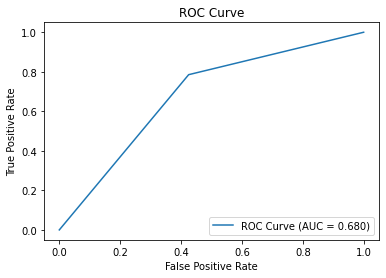

In [102]:
# Υπολογισμός των ποσοστών ψευδώς θετικών και αληθώς θετικών.
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lr)

# Plot της καμπύλης ROC
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.3f)' % lr_roc_score)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [105]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred_lr)
print(f'F1 Score: {f1:.3f}')

F1 Score: 0.742


### **KNN Algorithm**

0.694

Σημ: Με **Standard scaling**, το **accuracy** μας βγήκε **0.03** λιγότερο.

In [235]:
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

In [85]:
knn_mod = KNeighborsClassifier(n_neighbors = 30, metric = 'minkowski', p = 2)
knn_mod.fit(X_train, y_train)

# Πρόβλεψη μοντέλου
y_pred_knn = knn_mod.predict(X_test)

knn_accuracy = accuracy_score(y_test, y_pred_knn)
print(f'Accuracy: {knn_accuracy:.3f}')

Accuracy: 0.694


### **SVM Algorithm**
0.733

Σημ: **Αργεί** πάρα πολύ η εκπαίδευση του, σε σχέση με τα υπόλοιπα μοντέλα.

In [90]:
svm_mod = SVC(kernel="rbf", random_state=None, probability=True, cache_size=200, gamma=0.1) 
svm_mod.fit(X_train, y_train)

# Πρόβλεψη μοντέλου
y_pred_svm = svm_mod.predict(X_test)
SVM_accuracy = accuracy_score(y_test, y_pred_svm)

print(f'Accuracy: {SVM_accuracy:.3f}')

Accuracy: 0.733


### **Decision Tree**
0.677

In [89]:
DTC = DecisionTreeClassifier()
DTC.fit(X_train, y_train)

# Πρόβλεψη μοντέλου
y_pred_DTC = DTC.predict(X_test)

DTC_accuracy = accuracy_score(y_test, y_pred_DTC)

print(f'Accuracy: {DTC_accuracy:.3f}')

Accuracy: 0.677


### **Random Forest**
0.755

Το **καλύτερο** μας μοντέλο, με αρκετά μεγάλη διαφορά σε **accuracy**, καθώς και **πολύ γρήγορο** στην **εκπαίδευση** του.

In [283]:
rnf_mod =  RandomForestClassifier()
rnf_mod.fit(X_train, y_train)

# Πρόβλεψη μοντέλου
y_pred_rnf = rnf_mod.predict(X_test)

rnf_accuracy = accuracy_score(y_test, y_pred_rnf)

print(f'Accuracy: {rnf_accuracy:.3f}')

Accuracy: 0.755


### **Naive Bayes**
0.638

In [284]:
bayes_mod =  GaussianNB()
bayes_mod.fit(X_train, y_train)

# Πρόβλεψη
y_pred_bayes = bayes_mod.predict(X_test)

bayes_accuracy = accuracy_score(y_test, y_pred_bayes)

print(f'Accuracy: {bayes_accuracy:.3f}')

Accuracy: 0.638


### **Neural Network**
0.713

In [285]:
def NeuralN(X_train, X_test, y_train, y_test):

  model = keras.Sequential([
      layers.Input(shape=(X_train.shape[1],), name='input'),
      layers.Dense(100, activation='relu'),
      layers.Dense(100, activation='relu'),
      layers.Dense(100, activation='relu'),
      layers.Dense(100, activation='relu'),
      layers.Dense(3, activation='softmax', name='output')      
  ])

  model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
  )
  model.summary()
  history = model.fit(X_train, y_train, epochs=50, batch_size = 64)
  accuracy = model.evaluate(X_test, y_test)

  y_test_c = tf.keras.utils.to_categorical(y_test)

  y_pred = model.predict(X_test)
  pred_idx = np.argmax(y_pred, axis=1)
  true_idx = np.argmax(y_test_c, axis=1)
  tf_confmatrix = tf.math.confusion_matrix(true_idx, pred_idx)

  return accuracy, tf_confmatrix

In [286]:
nn_accuracy, tf_confmatrix = NeuralN(X_train, X_test, y_train, y_test)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 100)               10800     
                                                                 
 dense_9 (Dense)             (None, 100)               10100     
                                                                 
 dense_10 (Dense)            (None, 100)               10100     
                                                                 
 dense_11 (Dense)            (None, 100)               10100     
                                                                 
 output (Dense)              (None, 3)                 303       
                                                                 
Total params: 41,403
Trainable params: 41,403
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
138/138 [==============================

In [287]:
print(f'Accuracy: {nn_accuracy[1]:.3f}')

Accuracy: 0.713


### **Πίνακας με όλα τα accuracies**

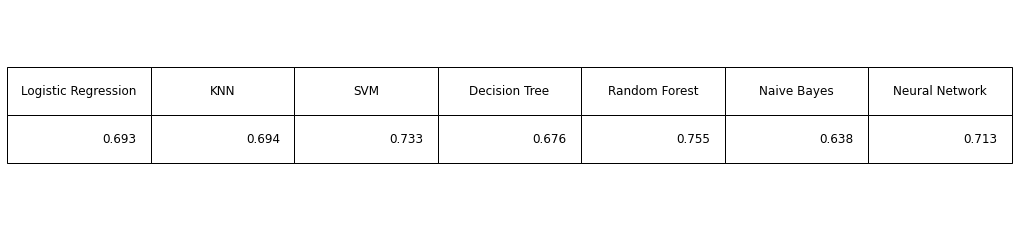

In [288]:
labels = ['Logistic Regression', 'KNN', 'SVM', 'Decision Tree',
          'Random Forest', 'Naive Bayes', 'Neural Network']

data = [[log_accuracy, knn_accuracy, SVM_accuracy, DTC_accuracy, rnf_accuracy, bayes_accuracy, nn_accuracy[1]]]

data = np.array(data)
data = np.round(data, 3)
fig, ax = plt.subplots()
table = ax.table(cellText=data, colLabels=labels, loc='center')
table.set_fontsize(20)
table.scale(3,4)
ax.axis('off')
ax.grid(False)

plt.show()

### **Confusion Matrix Plot (ίσως)**

In [289]:
def heat_confmatrix (confmatrix):
  
  labels = ['Accept', 'NotAccept']

  # Δίνουμε τα labels στον πίνακα
  conf_matr_plt = pd.DataFrame(confmatrix, index = labels, columns = labels)
  
  plt.subplots(figsize=(7, 5))
  
  ax = sns.heatmap(conf_matr_plt, cmap='viridis', annot=True, annot_kws={'size':20}, fmt="d")

  ax.xaxis.tick_top()
  ax.set_title("Confusion Matrix\n")
  plt.ylabel('True')
  plt.xlabel('Predicted')
  plt.show()

In [290]:
tf_confmatrix

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1077,  577],
       [ 510, 1619]], dtype=int32)>

## **Feature Selection (Λογικά όχι)**

In [ ]:
# randForest =  RandomForestClassifier()
# randForest.fit(X_train, y_train)

# importances = randForest.feature_importances_

# # sort the feature importances
# indices = np.argsort(importances)[::-1]

# # select the top 5 features
# selected_features = indices[:5]

# #Predict the response for test dataset
# y_pred_randForest = randForest.predict(X_test)

# rnf_accuracy = accuracy_score(y_test, y_pred_randForest)

# print(f'Accuracy: {rnf_accuracy:.3f}')

In [ ]:
# selected_features = selected_features.tolist()

In [ ]:
# print(selected_features)

In [ ]:
# df_new = df.iloc[:, selected_features]

In [ ]:
# df_new = pd.concat([df_new, df['Y']], axis=1)

In [ ]:
# df_new

In [ ]:
# newX = df_new.drop('Y', axis=1)
# newy = df_new['Y']
# newX_train, newX_test, newy_train, newy_test = train_test_split(newX, newy, train_size=0.7, random_state=42)

In [ ]:
# randForest =  RandomForestClassifier()
# randForest.fit(newX_train, newy_train)

# #Predict the response for test dataset
# newy_pred_randForest = randForest.predict(newX_test)

# new_rnf_accuracy = accuracy_score(newy_test, newy_pred_randForest)

# print(f'Accuracy: {new_rnf_accuracy:.3f}')

Accuracy: 0.609


## **2. Με χρήση υποσυνόλου 5 γνωρισμάτων**.
Αρχικά σκεφτήκαμε να δούμε τα γνωρίσματα τα οποία βγάζουν περισσότερο νοήμα σε εμας για να αποτελέσουν κριτήριο επιλογής κουπονιού. Ελέγξαμε το sec_df.groupby("")["Y"].mean() του κάθε γνωρίσματος για να δούμε πόσο διαφοροποιούνται οι μέσοι όροι των τιμών τους. Επειδή όμως με αυτό τον τρόπο ελέγχουμε μονομερώς το κάθε γνώρισμα αν παίρνει ή όχι το κουπόνι χωρίς να ελέγχουμε τα υπόλοιπα γνωρίσματα αποφασίσαμε να επιλέξουμε 5 γνωρίσματα σύμφωνα με κάποια δικά μας κριτήρια και να δούμε ποιος συνδιασμός επιτυγχάνει το μεγαλύτερο αποτέλεσμα.

In [291]:
sec_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12610 entries, 0 to 12683
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12610 non-null  object
 1   passanger             12610 non-null  object
 2   weather               12610 non-null  object
 3   temperature           12610 non-null  int64 
 4   time                  12610 non-null  object
 5   coupon                12610 non-null  object
 6   expiration            12610 non-null  object
 7   gender                12610 non-null  object
 8   age                   12610 non-null  object
 9   maritalStatus         12610 non-null  object
 10  has_children          12610 non-null  int64 
 11  education             12610 non-null  object
 12  occupation            12610 non-null  object
 13  income                12610 non-null  object
 14  Bar                   12610 non-null  object
 15  CoffeeHouse           12610 non-null

In [ ]:
# secX = sec_df.drop('Y', axis=1)
# secy = sec_df['Y']
# secX_train, secX_test, secy_train, secy_test = train_test_split(secX, secy, train_size=0.7, random_state=42)

In [ ]:
# df_corr = sec_df.corr()
# df_corr['Y']

In [ ]:
# sec_df = sec_df[["destination", "expiration", "education", "income", "toCoupon_GEQ25min", "Y"]]

### **One-hot Encoding**

In [ ]:
# secdf_categorical = sec_df.select_dtypes(exclude='number')
# secdf_categorical

In [ ]:
# for value in secdf_categorical:
#   sec_df= pd.get_dummies(sec_df,columns=[value])

In [ ]:
# sec_df.head()

In [ ]:
# sec_df.shape

### **Split dataset**

In [ ]:
# sec_X_train, sec_X_test, sec_y_train, sec_y_test = split_func(sec_df)

### **Random Forest**
Το μοντέλο με το καλύτερο **accuracy**.

In [ ]:
# randForest = RandomForestClassifier()
# randForest.fit(sec_X_train, sec_y_train)

# # Πρόβλεψη μοντέλου
# sec_y_pred_rnf = rnf_mod.predict(sec_X_test, sec_y_test)

# sec_rnf_accuracy = accuracy_score(sec_y_test, sec_y_pred_rnf)
# print(f'Accuracy: {sec_rnf_accuracy:.3f}')  

Accuracy: 0.62


# **Γ) Clustering / Συσταδοποίηση**
Στο **τρίτο και τελευταίο μέρος** θα αναπτυχθούν μοντέλα **συσταδοποίησης** και θα **εκπαιδευτούν** στο ήδη **καθαρισμένο** (από το **A μέρος**) **dataset** μας.

In [307]:
cluster_df.head()

,temperature,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,Y,destination_Home,destination_No Urgent Place,destination_Work,passanger_Alone,...,RestaurantLessThan20_1~3,RestaurantLessThan20_4~8,RestaurantLessThan20_gt8,RestaurantLessThan20_less1,RestaurantLessThan20_never,Restaurant20To50_1~3,Restaurant20To50_4~8,Restaurant20To50_gt8,Restaurant20To50_less1,Restaurant20To50_never
0,55,1,0,0,0,1,0,1,0,1,...,0,1,0,0,0,1,0,0,0,0
1,80,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
2,80,1,1,0,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
3,80,1,1,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
4,80,1,1,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0


In [298]:
cluster_df.shape

(12610, 108)

In [308]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_cluster_df = scaler.fit_transform(cluster_df)

## **PCA**
Επειδή έχουμε πάρα πολλά γνωρίσματα (**110 γνωρίσματα = 110 διαστάσεις**) και δεν μπορούμε να τα κάνουμε **plot** στον δισδιάστατο χώρο, θα χρησιμοποιήσουμε την τεχνική **επιλογής χαρακτηριστικών PCA** (**Ανάλυση κύριων συνιστωσών**) για να **μειώσουμε τη διαστατικότητα** των δεδομένων. Η **PCA** είναι μία τεχνική **χωρίς επίβλεψη** και δεν θα λάβει υπόψη τις ετικέτες των δεδομένων ("**Y**"), αλλά μπορεί να χρησιμοποιηθεί για να κάνει τη διαδικασία της συσταδοποίησης **πιο αποδοτική από υπολογιστική άποψη**. Να σημειωθέι ότι έχουμε την δυνατότητα να καθορίσουμε τον **αριθμό των συνιστωσών** που θέλουμε να διατηρήσουμε.

Επίσης η τεχνική αυτή συνίσταται με χρήση της **StandardScaler()** μιας και τα αποτελέσματα της είναι **πολύ ευαίσθητα** στην **κλιμάκωση των δεδομένων**. Βέβαια τα γνωρίσματα των δειγμάτων μας, πέραν του **temperature**, παίρνουν **τιμές 0 και 1**, οπότε **δεν θα χρειαστεί** η εφαρμογή του **StandardScaler()**.

In [309]:
from sklearn.decomposition import PCA

# Δημιουργία αντικειμένου PCA με το επιθυμητό πλήθος συνιστωσών.
pca = PCA(n_components=2)

# Μετασχηματισμός δεδομένων με χρήση του αντικειμένου PCA.
cluster_df_pca = pca.fit_transform(scaled_cluster_df)


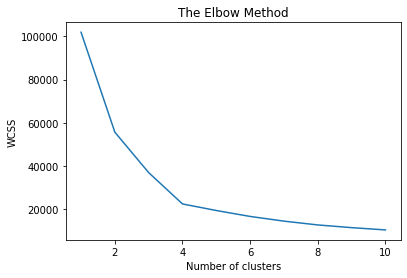

In [310]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(cluster_df_pca)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [311]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(cluster_df_pca)

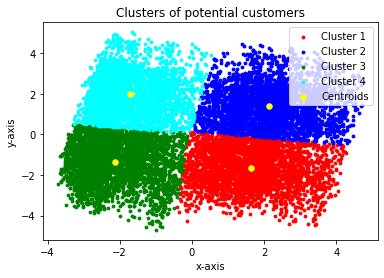

In [315]:
plt.scatter(cluster_df_pca[y_kmeans == 0, 0], cluster_df_pca[y_kmeans == 0, 1], s = 8, c = 'red', label = 'Cluster 1')
plt.scatter(cluster_df_pca[y_kmeans == 1, 0], cluster_df_pca[y_kmeans == 1, 1], s = 8, c = 'blue', label = 'Cluster 2')
plt.scatter(cluster_df_pca[y_kmeans == 2, 0], cluster_df_pca[y_kmeans == 2, 1], s = 8, c = 'green', label = 'Cluster 3')
plt.scatter(cluster_df_pca[y_kmeans == 3, 0], cluster_df_pca[y_kmeans == 3, 1], s = 8, c = 'cyan', label = 'Cluster 4')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 30, c = 'yellow', label = 'Centroids')
plt.title('Clusters of potential customers')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.legend()
plt.show()

In [317]:
from sklearn.metrics import silhouette_score

# Predict the cluster labels for each data point
cluster_pred = kmeans.predict(cluster_df_pca)

# Compute the silhouette score
score = silhouette_score(cluster_df_pca, cluster_pred)

# Print the silhouette score
print("Silhouette score: {:.3f}".format(score))


Silhouette score: 0.454
